In [1]:
# Get Omphalos github repository in path so modules can be loaded in
import sys
sys.path.insert(0,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos')
sys.path.insert(1,'/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github')

# Import generic data science modules
import numpy as np
import pandas as pd
import xarray as xr

# Import misc
import wandb
import xgboost as xgb
import re
from importlib import reload

# Import Omphalos modules.
from omphalos import file_methods as fm
from omphalos import attributes as attr
from omphalos import labels as lbls
from analysis import helper as hp

# Import plotting tools
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d

# Setup random state
random_state = 69
np.random.state = random_state
np.random.seed = random_state

/Users/thomasdodd/opt/anaconda3/envs/omphalos/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Define all the attributes we have varied in .yaml file
attribute_names = ["Al+++","Ca++","Fe++","K+","Na+","Mg++","SiO2(aq)","Cl-"]

In [3]:
# Retrieve the x and y normalisation factors used in the original training.
x_norms = [0.0199996777771118,0.0199998101672167,0.019999719657439,0.019999945896381,0.0199997455006281,0.0199994907051103,0.0199990220873342,0.0199997402413945]
y_norm = 96.2359084

# RTM Ground Truth Data

In [4]:
# Port in and unpack all the runs we need from the .pkl file.
CtrlSet_al_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/al/completed_run.pkl')
CtrlSet_ca_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/ca/completed_run.pkl')
CtrlSet_fe_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/fe/completed_run.pkl')
CtrlSet_k_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/k/completed_run.pkl')
CtrlSet_mg_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/mg/completed_run.pkl')
CtrlSet_na_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/na/completed_run.pkl')
CtrlSet_si_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/si/completed_run.pkl')
CtrlSet_cl_dict = fm.unpickle('/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/AI4ER/Easter/MRes/CrunchFlow_Work/bfm/2022-06-18_bfm_5-5_16000runs/control_tests/cl/completed_run.pkl')

In [5]:
# Create a number of datasets from the control RTM experiments
dataset_al_dict, error_dict = hp.filter_errors(CtrlSet_al_dict)
dataset_ca_dict, error_dict = hp.filter_errors(CtrlSet_ca_dict)
dataset_fe_dict, error_dict = hp.filter_errors(CtrlSet_fe_dict)
dataset_k_dict, error_dict = hp.filter_errors(CtrlSet_k_dict)
dataset_mg_dict, error_dict = hp.filter_errors(CtrlSet_mg_dict)
dataset_na_dict, error_dict = hp.filter_errors(CtrlSet_na_dict)
dataset_si_dict, error_dict = hp.filter_errors(CtrlSet_si_dict)
dataset_cl_dict, error_dict = hp.filter_errors(CtrlSet_cl_dict)

Returned 170 files without errors out of a total possible 200.
30 files had errors.
0 files had unhandled errors.
File failure rate: 17.647058823529413 %.
To see unhandled errors, run with verbose=True.
Returned 197 files without errors out of a total possible 200.
3 files had errors.
0 files had unhandled errors.
File failure rate: 1.5228426395939088 %.
To see unhandled errors, run with verbose=True.
Returned 199 files without errors out of a total possible 200.
1 files had errors.
0 files had unhandled errors.
File failure rate: 0.5025125628140703 %.
To see unhandled errors, run with verbose=True.
Returned 197 files without errors out of a total possible 200.
3 files had errors.
0 files had unhandled errors.
File failure rate: 1.5228426395939088 %.
To see unhandled errors, run with verbose=True.
Returned 199 files without errors out of a total possible 199.
0 files had errors.
0 files had unhandled errors.
File failure rate: 0.0 %.
To see unhandled errors, run with verbose=True.
Retu

In [6]:
# Get all the attribute df's for the control RTM experiments
attributes_al_df = attr.get_condition(dataset_al_dict,"f_i_onehundred",species_concs=True)
attributes_al_df = attributes_al_df.loc[:, attribute_names]
attributes_ca_df = attr.get_condition(dataset_ca_dict,"f_i_onehundred",species_concs=True)
attributes_ca_df = attributes_ca_df.loc[:, attribute_names]
attributes_fe_df = attr.get_condition(dataset_fe_dict,"f_i_onehundred",species_concs=True)
attributes_fe_df = attributes_fe_df.loc[:, attribute_names]
attributes_k_df = attr.get_condition(dataset_k_dict,"f_i_onehundred",species_concs=True)
attributes_k_df = attributes_k_df.loc[:, attribute_names]
attributes_mg_df = attr.get_condition(dataset_mg_dict,"f_i_onehundred",species_concs=True)
attributes_mg_df = attributes_mg_df.loc[:, attribute_names]
attributes_na_df = attr.get_condition(dataset_na_dict,"f_i_onehundred",species_concs=True)
attributes_na_df = attributes_na_df.loc[:, attribute_names]
attributes_si_df = attr.get_condition(dataset_si_dict,"f_i_onehundred",species_concs=True)
attributes_si_df = attributes_si_df.loc[:, attribute_names]
attributes_cl_df = attr.get_condition(dataset_cl_dict,"f_i_onehundred",species_concs=True)
attributes_cl_df = attributes_cl_df.loc[:, attribute_names]

/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)
/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary_species(data_set[i], condition), ignore_index=True)
/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/github/Omphalos/omphalos/attributes.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  species_attrs = species_attrs.append(primary

In [7]:
# function that takes a messy attribute df and the original dataset dictionary and returns a
# simplified attribute df and an array of corresponding targets.
def ControlData_CarbonateArrayRetriever(dataset_dictionary,attributes_df):
    NonCalSidMag_arr = ["Diopside","Diopside_a","Hedenbergite","Hedenbergite_a",
                    "Albite","Albite_a","Anorthite","Anorthite_a","M_Microcline",
                    "M_Microcline_a","M_Microcline_b","Forsterite","Forsterite_a",
                    "Fayalite","Fayalite_a","Antigorite","Antigorite_a","Greenalite",
                    "Greenalite_a","Calcite_a","Siderite_a","Magnesite_a"]
    CalSidMag_arr = ["Calcite","Siderite","Magnesite"]
    Vols_ds = lbls.raw(dataset_dictionary, 'volume')
    NrXDiscretisedBlocks = len(Vols_ds.X.values)
    EndVols_ds = Vols_ds.sel(time=280.0)
    CalSidMagEndVols_ds = EndVols_ds.drop(labels=NonCalSidMag_arr)

    CalSidMagEndVols_da = CalSidMagEndVols_ds.to_array(dim='arbitrary_array')
    CalSidMagEndVols_da = CalSidMagEndVols_da.astype(str)
    CalSidMagEndVols_da = CalSidMagEndVols_da.str.replace("^\d+\.\d+-\d+$", "0", regex=True)
    CalSidMagEndVols_da = CalSidMagEndVols_da.str.replace("^\d+\.\d+\+\d+$", "5000.0000", regex=True)
    CalSidMagEndVols_da = CalSidMagEndVols_da.astype(float)

    CalSidMagEndVols_ds = CalSidMagEndVols_da.to_dataset(dim="arbitrary_array")
    SpatialSummedCalSidMagEndVols_ds = CalSidMagEndVols_ds.sum(dim=["X","Y","Z"])
    SpatialSummedCarbEndVols_ds = SpatialSummedCalSidMagEndVols_ds.assign(Carbonates=lambda SpatialSummedCalSidMagEndVols_ds: SpatialSummedCalSidMagEndVols_ds.Calcite + SpatialSummedCalSidMagEndVols_ds.Siderite + SpatialSummedCalSidMagEndVols_ds.Magnesite)
    SpatialSummedCarbEndVols_arr = np.array(SpatialSummedCarbEndVols_ds.Carbonates.values)
    attributes_df['Carbonates_sum'] = SpatialSummedCarbEndVols_arr.tolist()

    attributes_df.loc[attributes_df['Carbonates_sum'] > (1*NrXDiscretisedBlocks), 'Carbonates_sum'] = np.nan
    attributes_df.loc[attributes_df['Carbonates_sum'] == np.inf, 'Carbonates_sum'] = np.nan
    attributes_df = attributes_df.dropna()
    attributes_df = attributes_df.reset_index(drop=True)
    attributes_df["Carbonates_avg"] = (attributes_df["Carbonates_sum"] / NrXDiscretisedBlocks)
    attributes_df["Carbonates_pct"] = (attributes_df["Carbonates_avg"] / 1) * 100
    CarbonatePct_arr = np.array(attributes_df["Carbonates_pct"])

    return CarbonatePct_arr, attributes_df

In [8]:
# Retrieval of xarray datasets containing final and initial mineralogical volume fractions for the control RTM experiments
CarbonatePct_al_arr,attributes_al_df = ControlData_CarbonateArrayRetriever(dataset_al_dict,attributes_al_df)
CarbonatePct_ca_arr,attributes_ca_df = ControlData_CarbonateArrayRetriever(dataset_ca_dict,attributes_ca_df)
CarbonatePct_fe_arr,attributes_fe_df = ControlData_CarbonateArrayRetriever(dataset_fe_dict,attributes_fe_df)
CarbonatePct_k_arr,attributes_k_df = ControlData_CarbonateArrayRetriever(dataset_k_dict,attributes_k_df)
CarbonatePct_mg_arr,attributes_mg_df = ControlData_CarbonateArrayRetriever(dataset_mg_dict,attributes_mg_df)
CarbonatePct_na_arr,attributes_na_df = ControlData_CarbonateArrayRetriever(dataset_na_dict,attributes_na_df)
CarbonatePct_si_arr,attributes_si_df = ControlData_CarbonateArrayRetriever(dataset_si_dict,attributes_si_df)
CarbonatePct_cl_arr,attributes_cl_df = ControlData_CarbonateArrayRetriever(dataset_cl_dict,attributes_cl_df)

In [9]:
# Control Experiments
# Split the datasets into x's and y's
# Normalise the control x's and y's in the same way as the training data


# Control 1 - Al+++ Varied, Ca++/Fe++/K+/Na+/Mg++/SiO2(aq)/Cl- Held-Steady
x_AlCtrl_matrix = attributes_al_df.loc[:, attribute_names].astype(float)
y_AlCtrl_arr = CarbonatePct_al_arr.astype(float)

x_AlCtrl_matrix = x_AlCtrl_matrix.to_numpy()
x_AlCtrl_norm_matrix = x_AlCtrl_matrix
for i, norm in enumerate(x_norms):
    x_AlCtrl_norm_matrix[:, i] = x_AlCtrl_norm_matrix[:, i]/norm

x_AlCtrl_norm_arr = np.hstack(x_AlCtrl_norm_matrix[:,0])
y_AlCtrl_norm_arr = np.hstack(y_AlCtrl_arr / y_norm) 


# Control 2 - Ca++ Varied, Al+++/Fe++/K+/Na+/Mg++/SiO2(aq)/Cl- Held-Steady
x_CaCtrl_matrix = attributes_ca_df.loc[:, attribute_names].astype(float)
y_CaCtrl_arr = CarbonatePct_ca_arr.astype(float)

x_CaCtrl_matrix = x_CaCtrl_matrix.to_numpy()
x_CaCtrl_norm_matrix = x_CaCtrl_matrix
for i, norm in enumerate(x_norms):
    x_CaCtrl_norm_matrix[:, i] = x_CaCtrl_norm_matrix[:, i]/norm

x_CaCtrl_norm_arr = np.hstack(x_CaCtrl_norm_matrix[:,1])
y_CaCtrl_norm_arr = np.hstack(y_CaCtrl_arr / y_norm)


# Control 3 - Fe++ Varied, Al+++/Ca++/K+/Na+/Mg++/SiO2(aq)/Cl- Held-Steady
x_FeCtrl_matrix = attributes_fe_df.loc[:, attribute_names].astype(float)
y_FeCtrl_arr = CarbonatePct_fe_arr.astype(float)

x_FeCtrl_matrix = x_FeCtrl_matrix.to_numpy()
x_FeCtrl_norm_matrix = x_FeCtrl_matrix
for i, norm in enumerate(x_norms):
    x_FeCtrl_norm_matrix[:, i] = x_FeCtrl_norm_matrix[:, i]/norm

x_FeCtrl_norm_arr = np.hstack(x_FeCtrl_norm_matrix[:,2])
y_FeCtrl_norm_arr = np.hstack(y_FeCtrl_arr / y_norm)


# Control 4 - K+ Varied, Al+++/Ca++/Fe++/Na+/Mg++/SiO2(aq)/Cl- Held-Steady
x_KCtrl_matrix = attributes_k_df.loc[:, attribute_names].astype(float)
y_KCtrl_arr = CarbonatePct_k_arr.astype(float)

x_KCtrl_matrix = x_KCtrl_matrix.to_numpy()
x_KCtrl_norm_matrix = x_KCtrl_matrix
for i, norm in enumerate(x_norms):
    x_KCtrl_norm_matrix[:, i] = x_KCtrl_norm_matrix[:, i]/norm

x_KCtrl_norm_arr = np.hstack(x_KCtrl_norm_matrix[:,3])
y_KCtrl_norm_arr = np.hstack(y_KCtrl_arr / y_norm)


# Control 5 - Na+ Varied, Al+++/Ca++/Fe++/K+/Mg++/SiO2(aq)/Cl- Held-Steady
x_NaCtrl_matrix = attributes_na_df.loc[:, attribute_names].astype(float)
y_NaCtrl_arr = CarbonatePct_na_arr.astype(float)

x_NaCtrl_matrix = x_NaCtrl_matrix.to_numpy()
x_NaCtrl_norm_matrix = x_NaCtrl_matrix
for i, norm in enumerate(x_norms):
    x_NaCtrl_norm_matrix[:, i] = x_NaCtrl_norm_matrix[:, i]/norm

x_NaCtrl_norm_arr = np.hstack(x_NaCtrl_norm_matrix[:,4])
y_NaCtrl_norm_arr = np.hstack(y_NaCtrl_arr / y_norm)


# Control 6 - Mg++ Varied, Al+++/Ca++/Fe++/K+/Na+/SiO2(aq)/Cl- Held-Steady
x_MgCtrl_matrix = attributes_mg_df.loc[:, attribute_names].astype(float)
y_MgCtrl_arr = CarbonatePct_mg_arr.astype(float)

x_MgCtrl_matrix = x_MgCtrl_matrix.to_numpy()
x_MgCtrl_norm_matrix = x_MgCtrl_matrix
for i, norm in enumerate(x_norms):
    x_MgCtrl_norm_matrix[:, i] = x_MgCtrl_norm_matrix[:, i]/norm

x_MgCtrl_norm_arr = np.hstack(x_MgCtrl_norm_matrix[:,5])
y_MgCtrl_norm_arr = np.hstack(y_MgCtrl_arr / y_norm)


# Control 7 - SiO2(aq) Varied, Al+++/Ca++/Fe++/K+/Na+/Mg++/Cl- Held-Steady
x_SiCtrl_matrix = attributes_si_df.loc[:, attribute_names].astype(float)
y_SiCtrl_arr = CarbonatePct_si_arr.astype(float)

x_SiCtrl_matrix = x_SiCtrl_matrix.to_numpy()
x_SiCtrl_norm_matrix = x_SiCtrl_matrix
for i, norm in enumerate(x_norms):
    x_SiCtrl_norm_matrix[:, i] = x_SiCtrl_norm_matrix[:, i]/norm

x_SiCtrl_norm_arr = np.hstack(x_SiCtrl_norm_matrix[:,6])
y_SiCtrl_norm_arr = np.hstack(y_SiCtrl_arr / y_norm)


# Control 8 - Cl- Varied, Al+++/Ca++/Fe++/K+/Na+/Mg++/SiO2(aq) Held-Steady
x_ClCtrl_matrix = attributes_cl_df.loc[:, attribute_names].astype(float)
y_ClCtrl_arr = CarbonatePct_cl_arr.astype(float)

x_ClCtrl_matrix = x_ClCtrl_matrix.to_numpy()
x_ClCtrl_norm_matrix = x_ClCtrl_matrix
for i, norm in enumerate(x_norms):
    x_ClCtrl_norm_matrix[:, i] = x_ClCtrl_norm_matrix[:, i]/norm

x_ClCtrl_norm_arr = np.hstack(x_ClCtrl_norm_matrix[:,7])
y_ClCtrl_norm_arr = np.hstack(y_ClCtrl_arr / y_norm)

In [10]:
def dictionary_maker(k_l, v_l):
    zip_iterator = zip(k_l, v_l)
    new_dictionary = dict(zip_iterator)
    return new_dictionary

In [11]:
def dictarray_retriever(searchDict,attrib):
    find_key = attrib
    res = list(searchDict.keys()).index(find_key)
    values = list(searchDict.items())
    dict_part = values[res]
    return dict_part[1]

In [12]:
attributes_RTMTruth_keys_list = attribute_names
attributes_RTMTruth_values_list = [x_AlCtrl_norm_arr, x_CaCtrl_norm_arr, x_FeCtrl_norm_arr, x_KCtrl_norm_arr, x_NaCtrl_norm_arr, x_MgCtrl_norm_arr, x_SiCtrl_norm_arr, x_ClCtrl_norm_arr]
attributes_RTMTruth_dict = dictionary_maker(attributes_RTMTruth_keys_list,attributes_RTMTruth_values_list)

target_RTMTruth_keys_list = attribute_names
target_RTMTruth_values_list = [y_AlCtrl_norm_arr, y_CaCtrl_norm_arr, y_FeCtrl_norm_arr, y_KCtrl_norm_arr, y_NaCtrl_norm_arr, y_MgCtrl_norm_arr, y_SiCtrl_norm_arr, y_ClCtrl_norm_arr]
target_RTMTruth_dict = dictionary_maker(target_RTMTruth_keys_list,target_RTMTruth_values_list)

# XGBoost Predicted Values

In [36]:
# Number of samples we'd like to get the model to predict on
samples = 15
# The controlled values in the base .in file
incontrolled_val = 1.00E-10

In [37]:
# (ab)normalization functions
def NormalizeData(data, upper):
    return data / upper
def AbNormalizeData(data, upper):
    return data * upper
def ScaleData(data, scale_factor):
    return data * scale_factor

In [38]:
def pred_getter(attrib_name,x_lower,x_upper,attrib_const_vals,attrib_names,samples,x_norms,y_norm,model_name):
    x_attrib_name = attrib_name

    matrix = np.full((samples,len(attrib_names)),10.01)

    x_arr = []

    i = 0
    for _,__,___ in zip(attrib_const_vals,attrib_names,x_norms):
        if __ == x_attrib_name:
            xpred = np.linspace(x_lower, x_upper, samples)

            x_arr.append(xpred)

            xpred_matrix = np.matrix(xpred)

            matrix[:,i] = xpred_matrix[0,:]
        else:
            default_arr = np.full((samples, 1), _)

            default_matrix = np.matrix(default_arr)

            matrix[:,i] = default_matrix[0,:]
        i+=1

    matrix_norm = matrix
    for i, norm in enumerate(x_norms):
        matrix_norm[:, i] = matrix_norm[:, i]/norm
    
    bst = xgb.Booster()
    bst.load_model(fname=model_name)

    y_arr_norm = bst.predict(xgb.DMatrix(matrix))
    y_arr = AbNormalizeData(y_arr_norm,y_norm)

    x_arr_scaled = ScaleData(np.array(x_arr),1000)

    return x_arr_scaled,y_arr

In [39]:
attribute_constant_vals = [0.00953981392737719,0.006229012131079079,0.018144146311725996,0.017110734975244037,0.018215952565736267,0.013919712364785673,0.01651024693344055,0.012756491752318355]

# RTM Ground Truth vs XGBoost Predictions - A Cross Comparison

In [50]:
model_names = ["bfm_XGBModel_5-5_Epo-3000.json","bfm_XGBModel_5-5_Epo-30000.json","bfm_XGBModel_5-5_Epo-300000.json"]
model_labels = ["XGB-3,000","XGB-30,000","XGB-300,000"]
graph_titles = ["A","B","C","D","E","F","G","H"]

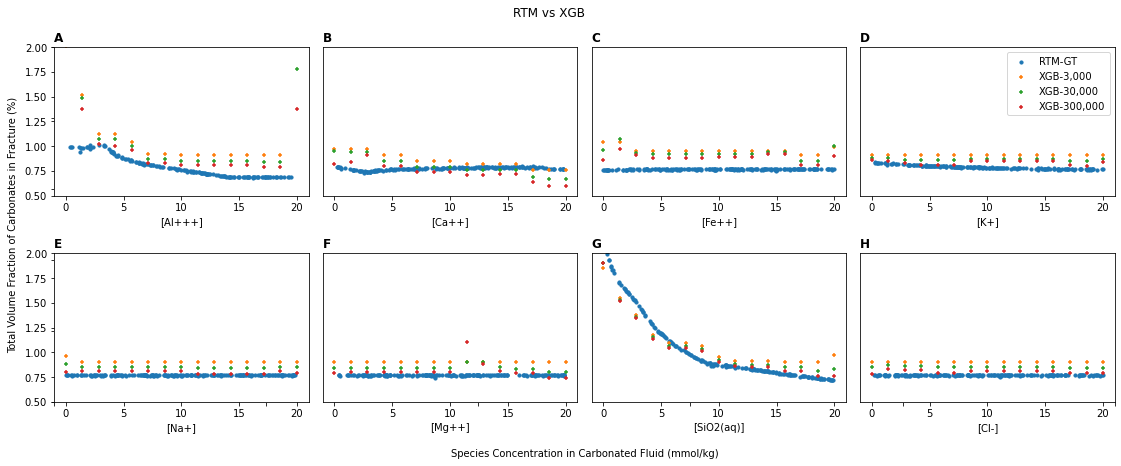

In [54]:
# Plotting the control RTM experiments against predictions made by the XGBoost Model

fig = plt.figure()
ax = fig.add_subplot(111)
ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242)
ax3 = fig.add_subplot(243)
ax4 = fig.add_subplot(244)
ax5 = fig.add_subplot(245)
ax6 = fig.add_subplot(246)
ax7 = fig.add_subplot(247)
ax8 = fig.add_subplot(248)

axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

fig.suptitle('RTM vs XGB')

fig.set_figheight(7)
fig.set_figwidth(16)

for attribute_name,axis,x_norm,graph_title in zip(attribute_names,axes,x_norms,graph_titles):
    axis.set_title(graph_title, loc='left',fontweight="bold")
    x_truth = dictarray_retriever(attributes_RTMTruth_dict,attribute_name)
    y_truth = dictarray_retriever(target_RTMTruth_dict,attribute_name)
    x_truth = x_truth * x_norm
    y_truth = y_truth * y_norm
    x_truth_scaled = ScaleData(x_truth, 1000)
    axis.scatter(x=x_truth_scaled, y=y_truth, s=10, alpha=1, label="RTM-GT")
    axis.set_xlabel(f'[{attribute_name}]')
    # axis.set_ylim(0.5, 1.5)
    axis.set_ylim(0.5, 2)

for attribute_name,axis in zip(attribute_names,axes):
    for model,model_label in zip(model_names,model_labels):
        x_pred,y_pred = pred_getter(attribute_name, 0, 0.02, attribute_constant_vals,attribute_names,samples,x_norms,y_norm,model)
        axis.scatter(x=x_pred, y=y_pred, s=15, alpha=1, label=model_label, marker="+")

ax4.legend()

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('w')
ax.spines['bottom'].set_color('w')
ax.spines['left'].set_color('w')
ax.spines['right'].set_color('w')
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
# ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_ylabel('Total Volume Fraction of Carbonates in Fracture (%)', labelpad=30)
ax.set_xlabel('Species Concentration in Carbonated Fluid (mmol/kg)', labelpad=40)

ax2.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax6.get_yaxis().set_visible(False)
ax7.get_yaxis().set_visible(False)
ax8.get_yaxis().set_visible(False)
plt.tight_layout()